In [2]:
import pandas as pd 
import numpy as np 

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, balanced_accuracy_score
import shap
from scipy.stats import  pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import scipy
import scipy.optimize as opt
from sklearn.metrics import roc_curve

In [3]:
data = pd.read_csv("/Users/alteafogh/Documents/ITU/AFAE/AFAE_dropout/data.csv", sep=";")

In [4]:
data

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [5]:
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

In [49]:
data["Gender"].value_counts()

0    2868
1    1556
Name: Gender, dtype: int64

In [6]:
data = data.drop(columns=["Nacionality", "Application mode","Previous qualification (grade)",
       'Mother\'s occupation', 'Father\'s occupation','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', "Tuition fees up to date",'Unemployment rate', 'Inflation rate', 'GDP'], axis=1)

In [7]:
data.columns

Index(['Marital status', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Mother's qualification', 'Father's qualification', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor', 'Gender',
       'Scholarship holder', 'Age at enrollment', 'International', 'Target'],
      dtype='object')

In [8]:
data["Mother's qualification"].value_counts()

# Define higher and non-higher education indices
higher_education = {2, 3, 4, 5, 6, 40, 41, 42, 43, 44}
non_higher_education = {7, 8, 9, 10, 11, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

# Map to binary values
data['mother_education'] = data["Mother's qualification"].apply(
    lambda x: 1 if x in higher_education else 0)


# higher education: (2, 3, 4, 5, 6, 40, 41, 42, 43, 44)
# not higher: 7, 8, 9, 10, 11, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24
data["Father's qualification"].value_counts()

# Map to binary values
data['father_education'] = data["Father's qualification"].apply(
    lambda x: 1 if x in higher_education else 0)
# higher edication: 2, 3, 4, 5, 6, 40, 41, 42, 43, 44
# non_ :1, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 

In [9]:
data = data.drop(columns=["Father's qualification","Mother's qualification" ], axis=1)

In [10]:
data.Course.value_counts() # we one hot encode them, and merge the day/evening ones

# 3, 10
# 9, 17

merge_map = {8014:9238, 9991:9147}
data["Course"] = data["Course"].replace(merge_map)
course_map = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education"
}
data["course_name"] = data["Course"].map(course_map)


data.Course.value_counts()
data = data.drop("Course", axis=1)

In [11]:
data["Previous qualification"].value_counts() # in three: you already have a higher edication, you don't have one, ypou haven't finished highschool (wtf)

already_higher = {2,3,4,5,6,40, 42, 43}
no_higher = {1,39}
non_secondary = {9,10,12,14,15,19,38}
# already have higher: 2, 3,4,5,6,15, 16, 17
# no higher: 1,14,  
# wtf: 7, 8, 9, 10, 11, 12, 13, 

def tri_map(value):
    if value in already_higher:
        return 1
    elif value in no_higher:
        return 0
    elif value in non_secondary:
        return 2
    else:
        return None

data["Previous_qualification"] = data["Previous qualification"].apply(tri_map)
data.drop("Previous qualification", axis=1, inplace=True)

In [12]:
data["Previous_qualification"].value_counts()

0    3936
1     256
2     232
Name: Previous_qualification, dtype: int64

In [13]:
data["Application order"] = data["Application order"] < 2
data["Application order"] = data["Application order"].astype(int)

In [14]:
data["Age at enrollment"] = data["Age at enrollment"] <=23
data["Age at enrollment"] =data["Age at enrollment"].astype(int)


In [15]:
data["Age at enrollment"].value_counts()

1    3155
0    1269
Name: Age at enrollment, dtype: int64

In [16]:
data.Target.value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [17]:
data["Target"] = data["Target"].map({"Graduate":1, "Dropout":0, "Enrolled":0})

In [18]:
data.Target.value_counts()


0    2215
1    2209
Name: Target, dtype: int64

In [20]:
data["Marital status"].value_counts()

1    3919
2     379
4      91
5      25
6       6
3       4
Name: Marital status, dtype: int64

In [21]:
data

,Marital status,Application order,Daytime/evening attendance\t,Admission grade,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,Age at enrollment,International,Target,mother_education,father_education,course_name,Previous_qualification
0,1,0,1,127.3,1,0,0,1,0,1,0,0,0,0,Animation and Multimedia Design,0
1,1,1,1,142.5,1,0,0,1,0,1,0,1,0,1,Tourism,0
2,1,0,1,124.8,1,0,0,1,0,1,0,0,0,0,Communication Design,0
3,1,0,1,119.6,1,0,0,0,0,1,0,1,0,0,Journalism and Communication,0
4,2,1,0,141.5,0,0,0,0,0,0,0,1,0,0,Social Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,0,1,122.2,0,0,0,1,0,1,0,1,0,0,Journalism and Communication,0
4420,1,0,1,119.0,1,0,1,0,0,1,1,0,0,0,Journalism and Communication,0
4421,1,1,1,149.5,1,0,0,0,1,0,0,0,0,0,Nursing,0
4422,1,1,1,153.8,1,0,0,0,1,1,0,1,0,0,Management,0


In [22]:
cols = ["Marital status","course_name", "Previous_qualification"]

df_processed = pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)

Glyph 9 (	) missing from current font.
Glyph 9 (	) missing from current font.


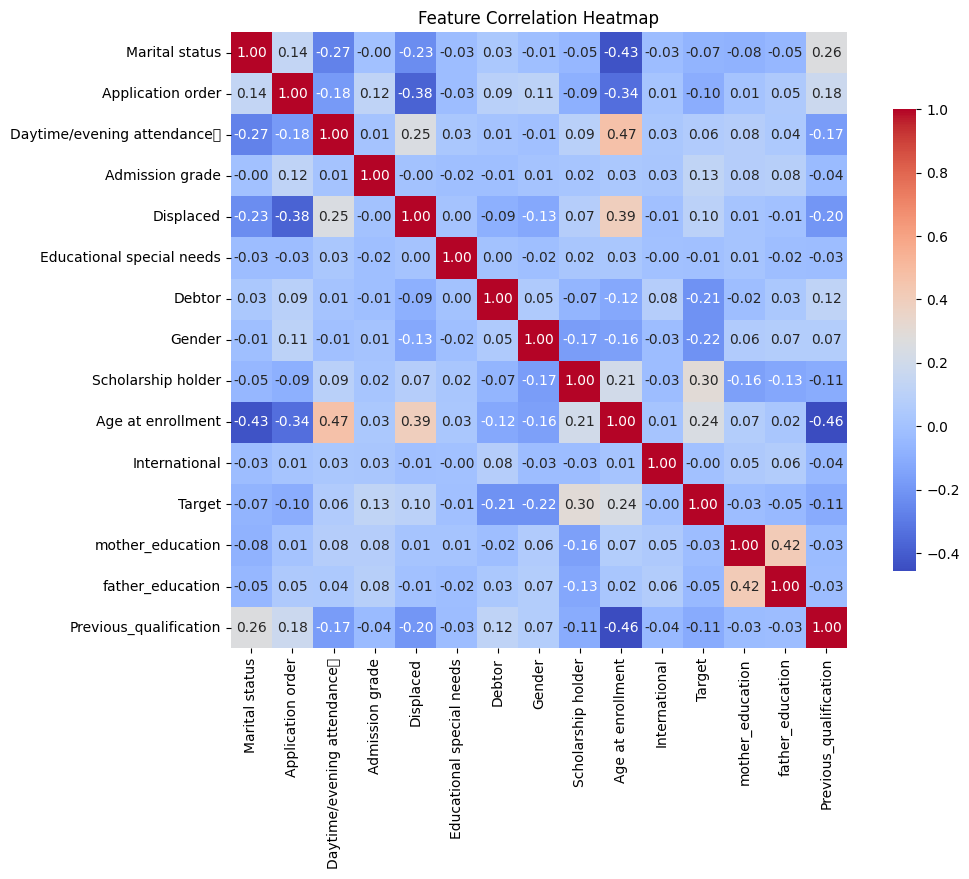

In [23]:


# Calculate correlation matrix
corr_matrix = data.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .75})

# Set title
plt.title("Feature Correlation Heatmap")

# Show plot
plt.show()

In [24]:
df_processed

,Application order,Daytime/evening attendance\t,Admission grade,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,Age at enrollment,International,...,course_name_Informatics Engineering,course_name_Journalism and Communication,course_name_Management,course_name_Nursing,course_name_Oral Hygiene,course_name_Social Service,course_name_Tourism,course_name_Veterinary Nursing,Previous_qualification_1,Previous_qualification_2
0,0,1,127.3,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,142.5,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,124.8,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,119.6,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,141.5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,0,1,122.2,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4420,0,1,119.0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
4421,1,1,149.5,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4422,1,1,153.8,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0


according to the paper, they want to predict before the beginning of the education, but if we do that, we don't give equal opportunities to everybody. 
they 

In [26]:
data.columns

Index(['Marital status', 'Application order', 'Daytime/evening attendance\t',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target', 'mother_education',
       'father_education', 'course_name', 'Previous_qualification'],
      dtype='object')

In [25]:
y = df_processed["Target"]
X = df_processed.drop("Target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# Choose only the columns you want to scale
cols_to_scale = ["Admission grade"]

# Fit scaler only on these columns
scaler = StandardScaler().fit(X_train[cols_to_scale])

# Transform only these columns
X_train_scaled_part = scaler.transform(X_train[cols_to_scale])
X_test_scaled_part = scaler.transform(X_test[cols_to_scale])

# Keep the other columns untouched
X_train_other = X_train.drop(columns=cols_to_scale)
X_test_other = X_test.drop(columns=cols_to_scale)



# Create DataFrames
X_train_scaled = pd.DataFrame(
    np.hstack([X_train_scaled_part, X_train_other.values]),
    columns=cols_to_scale + list(X_train_other.columns),
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    np.hstack([X_test_scaled_part, X_test_other.values]),
    columns=cols_to_scale + list(X_test_other.columns),
    index=X_test.index
)

In [27]:
X_train_scaled

,Admission grade,Application order,Daytime/evening attendance\t,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,Age at enrollment,International,...,course_name_Informatics Engineering,course_name_Journalism and Communication,course_name_Management,course_name_Nursing,course_name_Oral Hygiene,course_name_Social Service,course_name_Tourism,course_name_Veterinary Nursing,Previous_qualification_1,Previous_qualification_2
2863,-0.119226,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3136,-0.472154,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
725,0.904956,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2700,-0.043105,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2671,0.814994,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,-0.485994,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2157,2.288986,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3207,-1.046527,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4291,0.240621,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:

logistic_model = LogisticRegression(max_iter=5000, penalty=None, C=0.8497534359086438, tol=1e-4, solver="saga")

# Fit the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
log_y_pred = logistic_model.predict(X_test_scaled)
log_y_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

Setting penalty=None will ignore the C and l1_ratio parameters


In [29]:
log_accuracy = accuracy_score(y_test, log_y_pred)
log_accuracy

0.711864406779661

In [30]:
group_test_dict = {
    "Female": X_test_scaled["Gender"] == 0, 
    "Male": X_test_scaled["Gender"] == 1,
    "Over_23": X_test_scaled["Age at enrollment"] ==0,
    "Under_23": X_test_scaled["Age at enrollment"] ==1
}

In [31]:
# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], log_y_pred[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(log_y_pred[group_idxs]):.2f}')
    # Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Accuracy, {group}: {accuracy_score(y_test[group_idxs],log_y_pred[group_idxs]):.2f}')

for group, group_idxs in group_test_dict.items():
    print(f'Balanced Accuracy, {group}: {balanced_accuracy_score(y_test[group_idxs],log_y_pred[group_idxs]):.2f}')

F1, Female: 0.75
F1, Male: 0.57
F1, Over_23: 0.50
F1, Under_23: 0.74
Positive Rate, Female: 0.66
Positive Rate, Male: 0.25
Positive Rate, Over_23: 0.18
Positive Rate, Under_23: 0.65
Accuracy, Female: 0.69
Accuracy, Male: 0.75
Accuracy, Over_23: 0.77
Accuracy, Under_23: 0.69
Balanced Accuracy, Female: 0.67
Balanced Accuracy, Male: 0.69
Balanced Accuracy, Over_23: 0.66
Balanced Accuracy, Under_23: 0.67


Accuracy for Women (gender = 0) : 0.6901, f1-score: 0.7469 and balanced accuracy: 0.6728
Accuracy for Men (gender = 1) : 0.7542, f1-score: 0.5698 and balanced accuracy: 0.6889


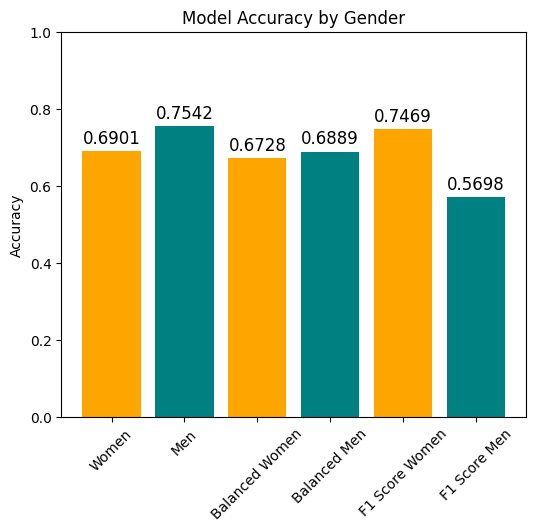

In [32]:
# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_women = (X_test_scaled['Gender'] == 0)  # Change to 0 for the other gender # Women
y_true_gender_women = y_test[gender_mask_women]
y_pred_gender_women = log_y_pred[gender_mask_women]
# Step 3: Compute accuracy for the selected gender

accuracy_women = accuracy_score(y_true_gender_women, y_pred_gender_women)
f1_score_women = f1_score(y_true_gender_women, y_pred_gender_women) 
balanced_accuracy_women = balanced_accuracy_score(y_true_gender_women, y_pred_gender_women)

print(f"Accuracy for Women (gender = 0) : {accuracy_women:.4f}, f1-score: {f1_score_women:.4f} and balanced accuracy: {balanced_accuracy_women:.4f}")

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_men = (X_test_scaled['Gender'] == 1)  # Change to 0 for the other gender # Women
y_true_gender_men = y_test[gender_mask_men]
y_pred_gender_men = log_y_pred[gender_mask_men]

# Step 3: Compute accuracy for the selected gender
accuracy_men = accuracy_score(y_true_gender_men, y_pred_gender_men)
f1_score_men = f1_score(y_true_gender_men, y_pred_gender_men) 
balanced_accuracy_men = balanced_accuracy_score(y_true_gender_men, y_pred_gender_men)

print(f"Accuracy for Men (gender = 1) : {accuracy_men:.4f}, f1-score: {f1_score_men:.4f} and balanced accuracy: {balanced_accuracy_men:.4f}")
# Accuracy values
genders = ["Women", "Men", "Balanced Women", "Balanced Men", "F1 Score Women", "F1 Score Men"]
accuracies = [accuracy_women, accuracy_men, balanced_accuracy_women, balanced_accuracy_men, f1_score_women, f1_score_men]

# Plot the accuracies
plt.figure(figsize=(6, 5))
plt.bar(genders, accuracies, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Gender")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

# fairness metrics and fixing them

calculating fairness metrics


In [34]:
def stat_parity(pred, feature):
    group1 = np.mean(pred[feature == 0]) 
    group2 = np.mean(pred[feature == 1]) 
    return group1, group2

def equal_odds(pred, target, feature):
    group1 = np.mean(pred[(y_test == target) & (feature == 0)])
    group2 = np.mean(pred[(y_test == target) & (feature == 1)])
    return group1, group2

def fairness(pred, feature):
    scores = [stat_parity(pred, feature), 
           equal_odds(pred, 0, feature), 
           equal_odds(pred, 1, feature)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["Older than 23", "Younger than 23"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return df_fair_metrics

log_fairness_age = fairness(log_y_pred, X_test_scaled["Age at enrollment"])


print(log_fairness_age)



      score       metric            group
0  0.184874  stat_parity    Older than 23
1  0.647604  stat_parity  Younger than 23
2  0.097701   eq_odds_t0    Older than 23
3  0.452962   eq_odds_t0  Younger than 23
4  0.421875   eq_odds_t1    Older than 23
5  0.802778   eq_odds_t1  Younger than 23


In [35]:
def stat_parity(pred, feature):
    group1 = np.mean(pred[feature == 0]) 
    group2 = np.mean(pred[feature == 1]) 
    return group1, group2

def equal_odds(pred, target, feature):
    group1 = np.mean(pred[(y_test == target) & (feature == 0)])
    group2 = np.mean(pred[(y_test == target) & (feature == 1)])
    return group1, group2

def fairness(pred, feature):
    scores = [stat_parity(pred, feature), 
           equal_odds(pred, 0, feature), 
           equal_odds(pred, 1, feature)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["female", "male"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return df_fair_metrics

log_fairness_gender = fairness(log_y_pred, X_test_scaled["Gender"])


print(log_fairness_gender)



      score       metric   group
0  0.664384  stat_parity  female
1  0.249169  stat_parity    male
2  0.470817   eq_odds_t0  female
3  0.127451   eq_odds_t0    male
4  0.816514   eq_odds_t1  female
5  0.505155   eq_odds_t1    male


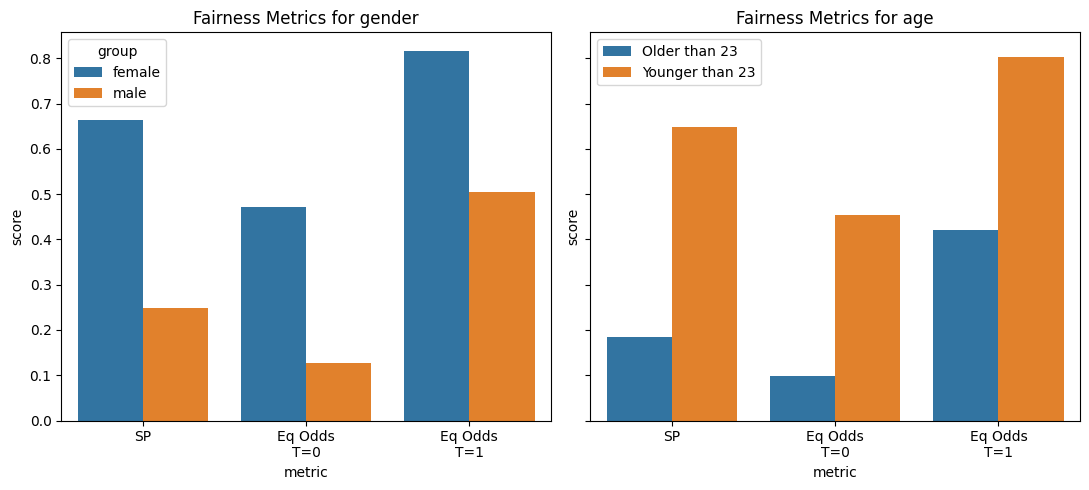

In [36]:
def plot_fairness(log_gender, log_age):
    _, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

    sns.barplot(data = log_gender,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[0]
                )

    sns.barplot(data = log_age,
                x = 'metric',
                y = 'score',
                hue= 'group',
                ax=ax[1]
                )

    plt.legend()
    ax[0].set_title("Fairness Metrics for gender")
    ax[1].set_title("Fairness Metrics for age")

    ax[0].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])
    ax[1].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])

    plt.tight_layout()

    plt.show()

plot_fairness(log_fairness_gender, log_fairness_age)

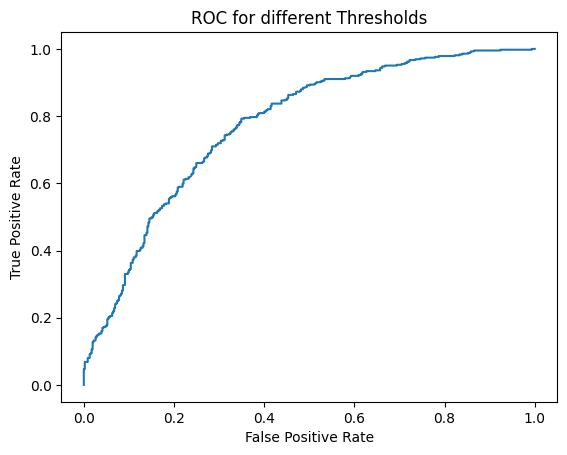

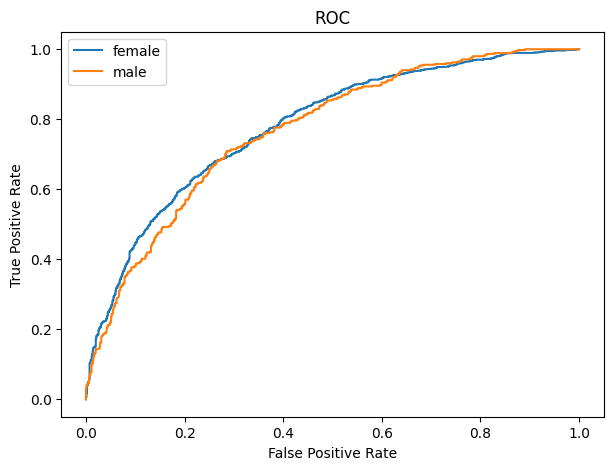

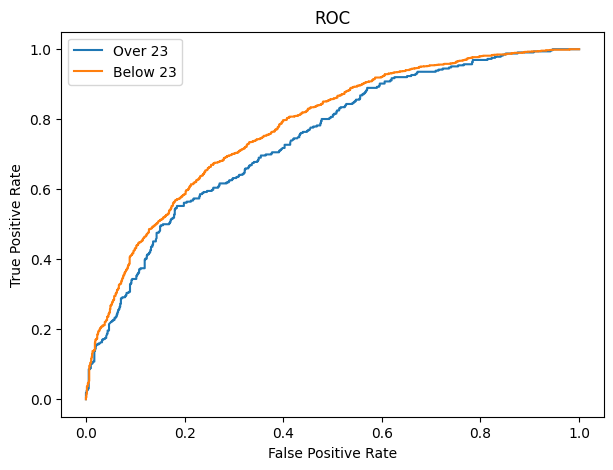

0.5467467319159357 0.3307307256914113
0.7049151082452961 0.8904095785488668


In [37]:
def roc_curve_generator(test, prob): 
    # Compute ROC curve 
    #false positive rate, true positive rate, threshold
    fpr, tpr, thr = roc_curve(test, prob, drop_intermediate=False)

    # Plot it
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set_title("ROC for different Thresholds")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")

def roc_curve_generator_groups(test_1, prob_1, test_2, prob_2, group_1, group_2): 
    fpr_1, tpr_1, thr_1 = roc_curve(test_1, prob_1, drop_intermediate=False)
    fpr_2, tpr_2, thr_2 = roc_curve(test_2, prob_2, drop_intermediate=False)

    tpr_diff = []
    fpr_diff = []
    thresholds = []
    for p in np.arange(0.1, 0.99, 0.001):
        tpr_diff.append(abs(tpr_1[tpr_1>p][0] - tpr_2[tpr_2>p][0]))
        fpr_diff.append(abs(fpr_1[tpr_1>p][0] - fpr_2[tpr_2>p][0]))
        thresholds.append((thr_1[tpr_1>p][0], thr_2[tpr_2>p][0]))

    diffs = []
    for i in range(len(fpr_diff)):
        diffs.append(abs(fpr_diff[i] - tpr_diff[i]))

    n = np.argmin(diffs)

    thr_group1, thr_group2 = thresholds[n]


    #plot
    _, ax = plt.subplots(1,1, figsize=(7,5))

    ax.plot(fpr_1, tpr_1, label=group_1)
    ax.plot(fpr_2, tpr_2, label=group_2)

    ax.set_title("ROC")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    plt.legend()
    plt.show()
    return thr_group1, thr_group2

roc_curve_generator(y_test, log_y_prob)


# separate ROC for each group
log_y_prob_female = logistic_model.predict_proba(X_train_scaled[X_train_scaled["Gender"]==0])[:,1]
log_y_prob_male = logistic_model.predict_proba(X_train_scaled[X_train_scaled["Gender"]==1])[:,1]
log_thr_female, log_thr_male = roc_curve_generator_groups(y_train[X_train_scaled["Gender"]==0], log_y_prob_female, y_train[X_train_scaled["Gender"]==1], log_y_prob_male, "female", "male")

# separate ROC for each group
log_y_prob_old = logistic_model.predict_proba(X_train_scaled[X_train_scaled["Age at enrollment"]==0])[:,1]
log_y_prob_young = logistic_model.predict_proba(X_train_scaled[X_train_scaled["Age at enrollment"]==1])[:,1]
log_thr_old, log_thr_young = roc_curve_generator_groups(y_train[X_train_scaled["Age at enrollment"]==0], log_y_prob_old, y_train[X_train_scaled["Age at enrollment"]==1], log_y_prob_young, "Over 23", "Below 23")


print(log_thr_female, log_thr_male)
print(log_thr_old, log_thr_young)




0.6745762711864407 0.5751412429378531
      score       metric   group
0  0.607877  stat_parity  Female
1  0.488372  stat_parity    Male
2  0.420233   eq_odds_t0  Female
3  0.367647   eq_odds_t0    Male
4  0.755352   eq_odds_t1  Female
5  0.742268   eq_odds_t1    Male       score       metric            group
0  0.067227  stat_parity    Older than 23
1  0.089645  stat_parity  Younger than 23
2  0.022989   eq_odds_t0    Older than 23
3  0.031359   eq_odds_t0  Younger than 23
4  0.187500   eq_odds_t1    Older than 23
5  0.136111   eq_odds_t1  Younger than 23


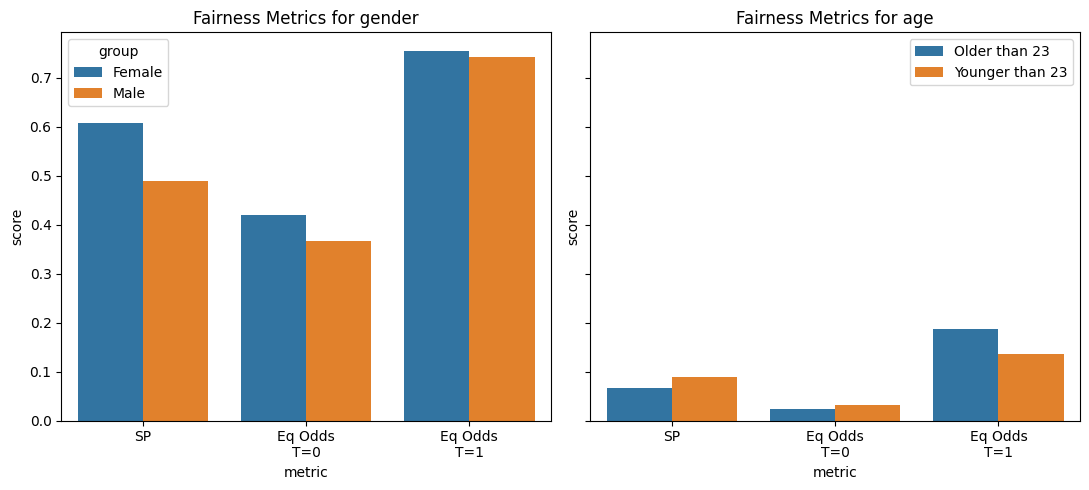

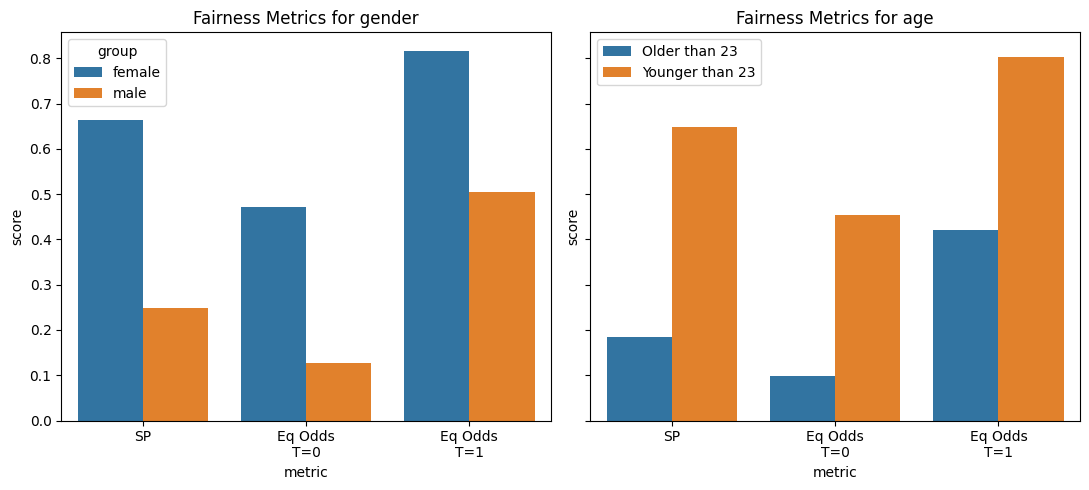

In [38]:
def new_accuracy(prob, thr_1, thr_2, feature_name, group_0, group_1):    
    new_pred = []
    for i, y in list(enumerate(prob)):
        if not X_test[feature_name].iloc[i]:
            if y >= thr_1:
                new_pred.append(1)
            else:
                new_pred.append(0)
        else: 
            if y >= thr_2:
                new_pred.append(1)
            else:
                new_pred.append(0)
    new_y_pred = pd.DataFrame()
    new_y_pred['group_test'] = X_test[feature_name]
    new_y_pred['y_test'] = y_test
    new_y_pred['pred'] = new_pred

    stp_1 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 0))
    stp_2 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 1))
    eq_odds_T1_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 0))
    eq_odds_T1_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 1))
    eq_odds_T0_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 0))
    eq_odds_T0_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 1))
    
    scores = [(stp_1,stp_2), 
           (eq_odds_T0_1,eq_odds_T0_2), 
           (eq_odds_T1_1,eq_odds_T1_2)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":[group_0, group_1]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return accuracy_score(y_test, new_pred), df_fair_metrics

new_log_accuracy_gender, new_log_fairness_gender = new_accuracy(log_y_prob, log_thr_female, log_thr_male,"Gender", "Female", "Male")
new_log_accuracy_age, new_log_fairness_age = new_accuracy(log_y_prob, log_thr_old, log_thr_young,"Age at enrollment", "Older than 23", "Younger than 23")

print(new_log_accuracy_gender,new_log_accuracy_age)
print(new_log_fairness_gender, new_log_fairness_age)


plot_fairness(new_log_fairness_gender, new_log_fairness_age)
plot_fairness(log_fairness_gender, log_fairness_age)

# logistic without protected features

In [39]:
X_train_np = X_train_scaled.drop(columns=["Gender", "Age at enrollment"], axis=1)
X_test_np = X_test_scaled.drop(columns=["Gender", "Age at enrollment"], axis=1)

In [40]:
logistic_model_np = LogisticRegression(max_iter=5000, penalty=None, C=0.8497534359086438, tol=1e-4, solver="saga")


logistic_model_np.fit(X_train_np, y_train)
log_y_pred_np = logistic_model_np.predict(X_test_np)
log_accuracy_np = accuracy_score(y_test, log_y_pred_np)
log_accuracy_np

Setting penalty=None will ignore the C and l1_ratio parameters


0.6892655367231638

Accuracy for Women (gender = 0) : 0.6781, f1-score: 0.7211 and balanced accuracy: 0.6692
Accuracy for Men (gender = 1) : 0.7110, f1-score: 0.5584 and balanced accuracy: 0.6732


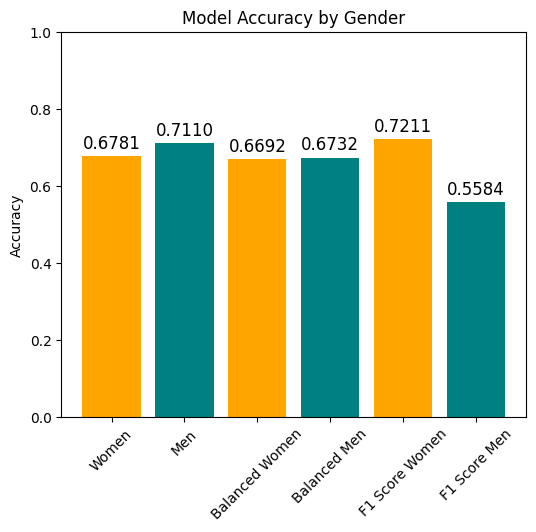

In [41]:
# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_women = (X_test_scaled['Gender'] == 0)  # Change to 0 for the other gender # Women
y_true_gender_women = y_test[gender_mask_women]
y_pred_gender_women_np = log_y_pred_np[gender_mask_women]
# Step 3: Compute accuracy for the selected gender

accuracy_women_np = accuracy_score(y_true_gender_women, y_pred_gender_women_np)
f1_score_women_np = f1_score(y_true_gender_women, y_pred_gender_women_np) 
balanced_accuracy_women_np = balanced_accuracy_score(y_true_gender_women, y_pred_gender_women_np)

print(f"Accuracy for Women (gender = 0) : {accuracy_women_np:.4f}, f1-score: {f1_score_women_np:.4f} and balanced accuracy: {balanced_accuracy_women_np:.4f}")

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_men = (X_test_scaled['Gender'] == 1)  # Change to 0 for the other gender # Women
y_true_gender_men = y_test[gender_mask_men]
y_pred_gender_men_np = log_y_pred_np[gender_mask_men]

# Step 3: Compute accuracy for the selected gender
accuracy_men_np = accuracy_score(y_true_gender_men, y_pred_gender_men_np)
f1_score_men_np = f1_score(y_true_gender_men, y_pred_gender_men_np) 
balanced_accuracy_men_np = balanced_accuracy_score(y_true_gender_men, y_pred_gender_men_np)

print(f"Accuracy for Men (gender = 1) : {accuracy_men_np:.4f}, f1-score: {f1_score_men_np:.4f} and balanced accuracy: {balanced_accuracy_men_np:.4f}")
# Accuracy values
genders = ["Women", "Men", "Balanced Women", "Balanced Men", "F1 Score Women", "F1 Score Men"]
accuracies = [accuracy_women_np, accuracy_men_np, balanced_accuracy_women_np, balanced_accuracy_men_np, f1_score_women_np, f1_score_men_np]

# Plot the accuracies
plt.figure(figsize=(6, 5))
plt.bar(genders, accuracies, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Gender")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

# fair PCA

In [42]:
X_train_scaled.columns

Index(['Admission grade', 'Application order', 'Daytime/evening attendance\t',
       'Displaced', 'Educational special needs', 'Debtor', 'Gender',
       'Scholarship holder', 'Age at enrollment', 'International',
       'mother_education', 'father_education', 'Marital status_2',
       'Marital status_3', 'Marital status_4', 'Marital status_5',
       'Marital status_6', 'course_name_Agronomy',
       'course_name_Animation and Multimedia Design',
       'course_name_Basic Education',
       'course_name_Biofuel Production Technologies',
       'course_name_Communication Design', 'course_name_Equinculture',
       'course_name_Informatics Engineering',
       'course_name_Journalism and Communication', 'course_name_Management',
       'course_name_Nursing', 'course_name_Oral Hygiene',
       'course_name_Social Service', 'course_name_Tourism',
       'course_name_Veterinary Nursing', 'Previous_qualification_1',
       'Previous_qualification_2'],
      dtype='object')

In [46]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        Xs = Xs.values
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(X_train, [6,8], 30)
Xs_train_debiased = fair_pca.project(X_train)
Xs_test_debiased = fair_pca.project(X_test)

In [47]:
X_train_p = X_train_scaled[["Gender", "Age at enrollment"]]
X_test_p = X_test_scaled[["Gender", "Age at enrollment"]]

Glyph 9 (	) missing from current font.
Glyph 9 (	) missing from current font.


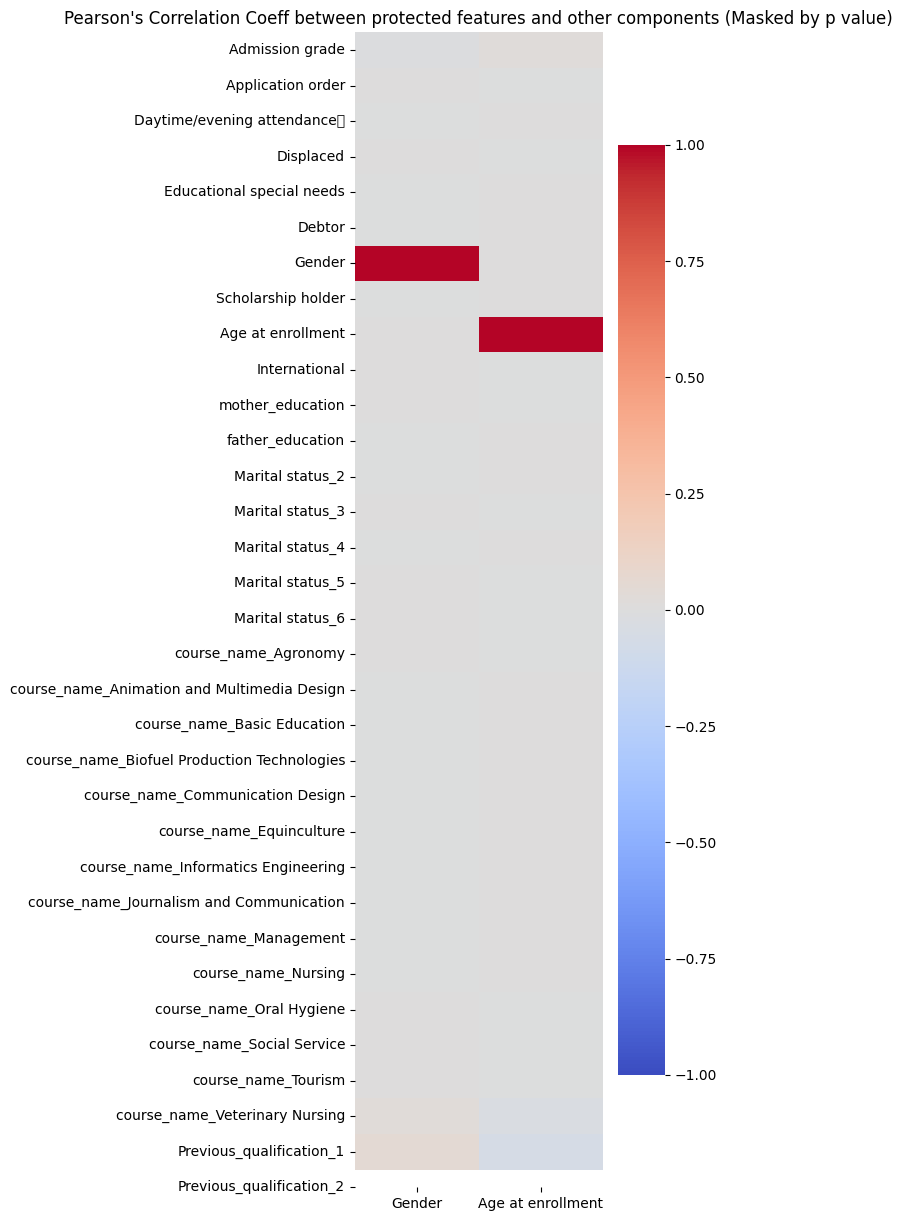

In [48]:
# Compute correlation matrix
Xs_train_debiased_p = np.concatenate([Xs_train_debiased, X_train_p], axis=1)
n_features = Xs_train_debiased_p.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
        corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_[:, [6, 8]], cmap="coolwarm", 
            xticklabels=["Gender", "Age at enrollment"], yticklabels=X_train_scaled.columns,
            vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between protected features and other components (Masked by p value)")
plt.show()